<a href="https://colab.research.google.com/github/aksu143/Capstone/blob/dev%2Fcapstone/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import io
import os

In [ ]:
from tensorflow.keras.utils import plot_model

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from keras.models import load_model

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Input, Embedding, Activation, RepeatVector, Dropout, BatchNormalization, Flatten, Bidirectional, TimeDistributed, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

pd.set_option('display.max_colwidth', 200)

import random
random.seed(0)
import re
import string
import warnings
warnings.filterwarnings("ignore")
from numpy import array, argmax, random, take

nltk.download('stopwords',quiet=True)
nltk.download('wordnet', quiet=True)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
combined_dataset = pd.read_csv('/content/drive/MyDrive/combined_dataset.csv')

In [ ]:
combined_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201936 entries, 0 to 201935
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   German   201795 non-null  object
 1   English  201936 non-null  object
dtypes: object(2)
memory usage: 3.1+ MB


In [ ]:
# Observing the shape of merged dataframes

combined_dataset.shape

(201936, 2)

In [ ]:
# Observing the top 5 entries of merged dataframe

combined_dataset.head()

,German,English
0,Steigt Gold auf 10.000 Dollar?\n,"$10,000 Gold?\n"
1,"SAN FRANCISCO – Es war noch nie leicht, ein ra...",SAN FRANCISCO – It has never been easy to have...
2,In letzter Zeit allerdings ist dies schwierige...,"Lately, with gold prices up more than 300% ove..."
3,Erst letzten Dezember verfassten meine Kollege...,"Just last December, fellow economists Martin F..."
4,"Und es kam, wie es kommen musste.\n",Wouldn’t you know it?\n


In [ ]:
# Dropping the null values from the dataframe

combined_dataset.dropna()

,German,English
0,Steigt Gold auf 10.000 Dollar?\n,"$10,000 Gold?\n"
1,"SAN FRANCISCO – Es war noch nie leicht, ein ra...",SAN FRANCISCO – It has never been easy to have...
2,In letzter Zeit allerdings ist dies schwierige...,"Lately, with gold prices up more than 300% ove..."
3,Erst letzten Dezember verfassten meine Kollege...,"Just last December, fellow economists Martin F..."
4,"Und es kam, wie es kommen musste.\n",Wouldn’t you know it?\n
...,...,...
201790,Das bleibt eine der größten Errungenschaften i...,It didn’t have to be this way.\n
201791,Gleichzeitig scheint sich Zumas revolutionäre ...,This past year has seen one missed opportunity...
201792,"In einer Region, wo die älteren Menschen sehr ...",South African president Thabo Mbeki convened n...
201793,Drei von zehn Südafrikanern sind jünger als 15...,Some African leaders – notably Ghana’s preside...


In [ ]:
# Dropping the duplicates from the dataframe

combined_dataset = combined_dataset.drop_duplicates()

In [ ]:
# Observing shape of the dataframe after dropping null values and duplicates

combined_dataset.shape

(201936, 2)

In [ ]:
# Randomly sample 5% of dataframe

combined_dataset_sample = combined_dataset.sample(frac = 0.005)

In [ ]:
# Observing the shape of sampled dataframe

combined_dataset_sample.shape

(1010, 2)

In [ ]:
# Adding columns in the dataframe which shows the length of each English and German sentence

combined_dataset_sample['eng_length'] = combined_dataset_sample['English'].str.len()

combined_dataset_sample['ger_length'] = combined_dataset_sample['German'].str.len()

In [ ]:
# Observing the information of sampled dataframe

combined_dataset_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1010 entries, 48139 to 193695
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   German      1009 non-null   object 
 1   English     1010 non-null   object 
 2   eng_length  1010 non-null   int64  
 3   ger_length  1009 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 39.5+ KB


In [ ]:
# Observing top 5 entries of the sampled dataframe

combined_dataset_sample.head(5)

,German,English,eng_length,ger_length
48139,"Haben tschetschenische Frauen, Kinder und die ...",Taiwan deserves great credit for standing on i...,108,145.0
39783,Zellen mit mutierten BRCA1- bzw. BRCA2-Genen j...,People defecating and urinating.\n,33,201.0
80606,"In diesem Zusammenhang ist bemerkenswert, dass...",We can be appropriately modest about our knowl...,135,255.0
162409,Eine jüngste Übersicht der Shanghaier Börse fa...,"Despite much hue and cry about it, governments...",110,123.0
198635,Zumindest in manchen Gegenden wurde die Weltba...,"In 1980, the French clown Coluche actually dro...",196,250.0


In [ ]:
def clean_sentence(sentence):
    sentence = sentence.lower()  #Convert to lowercase
    sentence = re.sub(r'\s+', ' ', sentence)  # Remove new line character
    sentence = sentence.strip()  # Remove leading and trailing white spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Replace multiple spaces with a single space
    sentence = re.sub(r'[^\w\s.,!?\'"]', '', sentence)  # Remove special characters except common punctuation
    sentence = 'START_ '+ sentence + ' _END'
    return sentence

In [ ]:
# Calling process_data function on the sampled dataframe

combined_dataset_sample['German'] = combined_dataset_sample['German'].astype(str).apply(clean_sentence)

In [ ]:
combined_dataset_sample['English'] = combined_dataset_sample['English'].astype(str).apply(clean_sentence)

In [ ]:
# Observing top 5 entries of the processed dataframe

combined_dataset_sample.head(5)

,German,English,eng_length,ger_length
48139,"START_ haben tschetschenische frauen, kinder u...",START_ taiwan deserves great credit for standi...,108,145.0
39783,START_ zellen mit mutierten brca1 bzw. brca2ge...,START_ people defecating and urinating. _END,33,201.0
80606,START_ in diesem zusammenhang ist bemerkenswer...,START_ we can be appropriately modest about ou...,135,255.0
162409,START_ eine jüngste übersicht der shanghaier b...,"START_ despite much hue and cry about it, gove...",110,123.0
198635,START_ zumindest in manchen gegenden wurde die...,"START_ in 1980, the french clown coluche actua...",196,250.0


Pre Processing - Dataset suitable to be used for AIML model learning

In [ ]:
# Function to generate word tokens
from tensorflow.keras.preprocessing.text import Tokenizer

def tokenize(sentences):
    # Create tokenizer
    text_tokenizer = Tokenizer()

    # Fit texts
    text_tokenizer.fit_on_texts(sentences)
    return text_tokenizer.texts_to_sequences(sentences), text_tokenizer

In [ ]:
# Generate word index

eng_tokenized, eng_tokenizer = tokenize(combined_dataset_sample['English'])
ger_tokenized, ger_tokenizer = tokenize(combined_dataset_sample['German'])

eng_word_index = eng_tokenizer.word_index
ger_word_index = ger_tokenizer.word_index

In [ ]:
# Finding the vocabulary size with number of unique tokens

english_vocab = len(eng_tokenizer.word_index) + 1
german_vocab = len(ger_tokenizer.word_index) + 1

print("English vocabulary is of {} unique words".format(english_vocab))
print("german vocabulary is of {} unique words".format(german_vocab))

English vocabulary is of 5404 unique words
german vocabulary is of 6633 unique words


In [ ]:
# Define the parameters

maxlen_eng = int(len(max(eng_tokenized, key=len)))
maxlen_ger = int(len(max(ger_tokenized, key=len)))

print("Maximum Length of English tokens is {}".format(maxlen_eng))
print("Maximum Length of German tokens is {}".format(maxlen_ger))

Maximum Length of English tokens is 95
Maximum Length of German tokens is 80


In [ ]:
# Generate token sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
eng_pad_sentence = pad_sequences(eng_tokenized, maxlen_eng, padding = "post")
ger_pad_sentence = pad_sequences(ger_tokenized, maxlen_ger, padding = "post")

print('Number of English Samples are {}:', len(eng_pad_sentence))
print('Number of German Samples are {}:', len(ger_pad_sentence))

Number of English Samples are {}: 1010
Number of German Samples are {}: 1010


Model Design

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(eng_pad_sentence,ger_pad_sentence,test_size=0.25,shuffle=True,random_state=101)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(757, 95)
(253, 95)
(757, 80)
(253, 80)


In [ ]:
combined_dataset_sample = combined_dataset_sample[combined_dataset_sample.English.str.count('\s+').lt(6)]

combined_dataset_sample = combined_dataset_sample.astype(str).applymap(lambda x: str(x.replace('\n','')))

combined_dataset_sample['German'] = combined_dataset_sample['German'].str.strip()

combined_dataset_sample['English'] = combined_dataset_sample['English'].str.strip()

combined_dataset_sample = combined_dataset_sample.replace('', np.nan)

combined_dataset_sample = combined_dataset_sample.dropna()

In [ ]:
combined_dataset_sample.count('index')

,0
German,44
English,44
eng_length,44
ger_length,44


In [ ]:
combined_dataset_sample.head(10)

,German,English,eng_length,ger_length
39783,START_ zellen mit mutierten brca1 bzw. brca2genen jedoch sind nicht zur rekombination befähigt und deshalb sehr viel empfindlicher gegenüber einer erhöhten anzahl von nicht reparierten einzelstran...,START_ people defecating and urinating. _END,33,201.0
115577,"START_ george akerlof und ich haben gerade ein buch mit diesem titel geschrieben, aber wenn animal spirits diesen winter erscheint, könnte der zustand der weltwirtschaft noch viel schlechter sein ...",START_ georgians share that enthusiasm. _END,33,200.0
141970,"START_ angesichts der seit ende 2005 um 200 basispunkte gestiegenen zinsen und eines euro, der einen neuen absoluten höchststand anpeilt, will sarkozy, dass die ezb sofort mit zinserhöhungen schlu...","START_ when in doubt, fire. _END",21,199.0
47434,START_ allerdings wendet der oberste militärrat eine ähnliche strategie an ihm geht es um die stärkung seines einflusses auf die wichtigsten machtministerien. _END,START_ egypts revolution continues. _END,30,153.0
12870,START_ ernennungen. _END,START_ appointments. _END,14,13.0
152181,"START_ wenn sie in die zukunft schauen, was halten sie für wahrscheinlicher? werden wir landesweit während der nächsten etwa fünf jahre eine gute zeit haben, oder sehen sie eher perioden hoher arb...",START_ they could be right. _END,21,238.0
52203,"START_ chirac ist es besser ergangen, hauptsächlich weil er den jovialen umgang mit den wählern besser beherrscht. _END","START_ in a word, no. _END",15,108.0
144678,START_ tatsächlich werden die neuen eumitglieder ihre treibhausgasemissionen bis 2010 voraussichtlich um mindestens 21 verringern. _END,START_ confluence _END,12,127.0
43399,"START_ das faktische exportverbot für seltenerdmetalle die häufig als die vitamine der industrie bezeichnet werden, hat den japanischen unternehmen, die für 97 ihres bedarfs auf china angewiesen ...",START_ dignity or decline? _END,20,236.0
36934,"START_ sobald diese gräueltaten entdeckt wurden, hat die regierung schnell gehandelt. _END",START_ but no more. _END,13,79.0


In [ ]:
np.savetxt('/content/drive/MyDrive/Colab Notebooks/combined_english_german.txt', combined_dataset_sample.to_numpy(), delimiter='\t', fmt='%s')

In [ ]:
def load_doc(filename):

    # open the file as read only
    file = open(filename, mode='rt', encoding='utf-8')

    # read all text
    text = file.read()

    # close the file
    file.close()

    return text

In [ ]:
def to_pairs(doc):
    lines = doc.strip().split('\n')
    pairs = [line.split('\t') for line in  lines]
    return pairs

In [ ]:
from unicodedata import normalize

# Function to clean a list of lines

def clean_pairs(lines):
    cleaned = list()

    # prepare regex for char filtering
    re_print = re.compile('[^%s]' % re.escape(string.printable))

    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)

    for pair in lines:
        clean_pair = list()
        for line in pair:
            # normalize unicode characters
            line = normalize('NFD', line).encode('ascii', 'ignore')
            line = line.decode('UTF-8')

            # tokenize on white space
            line = line.split()

            # convert to lowercase
            line = [word.lower() for word in line]

            # remove punctuation from each token
            line = [word.translate(table) for word in line]

            # remove non-printable chars form each token
            line = [re_print.sub('', w) for w in line]

            # remove tokens with numbers in them
            line = [word for word in line if word.isalpha()]

            # store as string
            clean_pair.append(' '.join(line))
        cleaned.append(clean_pair)
    return array(cleaned)

In [ ]:
from pickle import load,dump
def save_clean_data(sentences, filename):
    dump(sentences, open(filename, 'wb'))
    print('Saved: %s' % filename)

In [ ]:
filename = '/content/drive/MyDrive/Colab Notebooks/combined_english_german.txt'

doc = load_doc(filename)

# Calling to_pair function to split dat into english-german pairs
pairs = to_pairs(doc)

# Calling clean_pair function to clean the sentences
clean_pairs = clean_pairs(pairs)

# Calling save_clean_data function to save clean pairs into file
save_clean_data(clean_pairs, '/content/drive/MyDrive/Colab Notebooks/german-english1.pkl')

Saved: /content/drive/MyDrive/Colab Notebooks/german-english1.pkl


In [ ]:
def load_clean_sentences(filename):
    return load(open(filename, 'rb'))

In [ ]:
print(clean_pairs.size)

176


In [ ]:
from numpy.random import shuffle

# Loading clean dataset
raw_dataset = load_clean_sentences('/content/drive/MyDrive/Colab Notebooks/german-english1.pkl')

# Reducing dataset size
n_sentences = clean_pairs.size
dataset = raw_dataset[:n_sentences, :]

# Randomly shuffling the dataset
shuffle(dataset)

# Generating train and test datasets
train, test = train_test_split(dataset, test_size=0.25, random_state=1)

# Saving clean, train, test dataset into pickle file
save_clean_data(dataset, '/content/drive/MyDrive/Colab Notebooks/english-german-both1.pkl')
save_clean_data(train, '/content/drive/MyDrive/Colab Notebooks/english-german-train1.pkl')
save_clean_data(test, '/content/drive/MyDrive/Colab Notebooks/english-german-test1.pkl')

Saved: /content/drive/MyDrive/Colab Notebooks/english-german-both1.pkl
Saved: /content/drive/MyDrive/Colab Notebooks/english-german-train1.pkl
Saved: /content/drive/MyDrive/Colab Notebooks/english-german-test1.pkl


In [ ]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [ ]:
def max_length(lines):
    return max(len(line.split()) for line in lines)

In [ ]:
def encode_sequences(tokenizer, length, lines):
    X = tokenizer.texts_to_sequences(lines)

    # padding sequences with 0 values
    X = pad_sequences(X, maxlen=length, padding='post')

    return X

In [ ]:
from keras.utils import to_categorical

# Function to convert vectors into binary matrix

def encode_output(sequences, vocab_size):
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y

In [ ]:
dataset = load_clean_sentences('/content/drive/MyDrive/Colab Notebooks/english-german-both1.pkl')
train = load_clean_sentences('/content/drive/MyDrive/Colab Notebooks/english-german-train1.pkl')
test = load_clean_sentences('/content/drive/MyDrive/Colab Notebooks/english-german-test1.pkl')

In [ ]:
eng_tokenizer_rnn = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer_rnn.word_index) + 1
eng_length_rnn = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length_rnn))

# Preparing German tokenizer

ger_tokenizer_rnn = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer_rnn.word_index) + 1
ger_length_rnn = max_length(dataset[:, 1])
print('German Vocabulary Size: %d' % ger_vocab_size)
print('German Max Length: %d' % (ger_length_rnn))

English Vocabulary Size: 519
English Max Length: 41
German Vocabulary Size: 108
German Max Length: 6


In [ ]:
# prepare training data
trainX = encode_sequences(ger_tokenizer_rnn, ger_length_rnn, train[:, 1])
trainY = encode_sequences(eng_tokenizer_rnn, eng_length_rnn, train[:, 0])
trainY = encode_output(trainY, eng_vocab_size)

# prepare validation data
testX = encode_sequences(ger_tokenizer_rnn, ger_length_rnn, test[:, 1])
testY = encode_sequences(eng_tokenizer_rnn, eng_length_rnn, test[:, 0])
testY = encode_output(testY, eng_vocab_size)

In [ ]:
def define_simple_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    model = Sequential()
    model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    model.add(SimpleRNN(n_units))
    model.add(RepeatVector(tar_timesteps))
    model.add(SimpleRNN(n_units, return_sequences=True))
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
    return model

In [ ]:
model_translate_RNN = define_simple_model(ger_vocab_size, eng_vocab_size, ger_length_rnn, eng_length_rnn, 256)

In [ ]:
model_translate_RNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_translate_RNN.build(input_shape=(None, 3))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 3, 256)              │          27,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 41, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 41, 256)             │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 41, 519)             │         133,383 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 423,687 (1.62 MB)

 Trainable params: 423,687 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

None


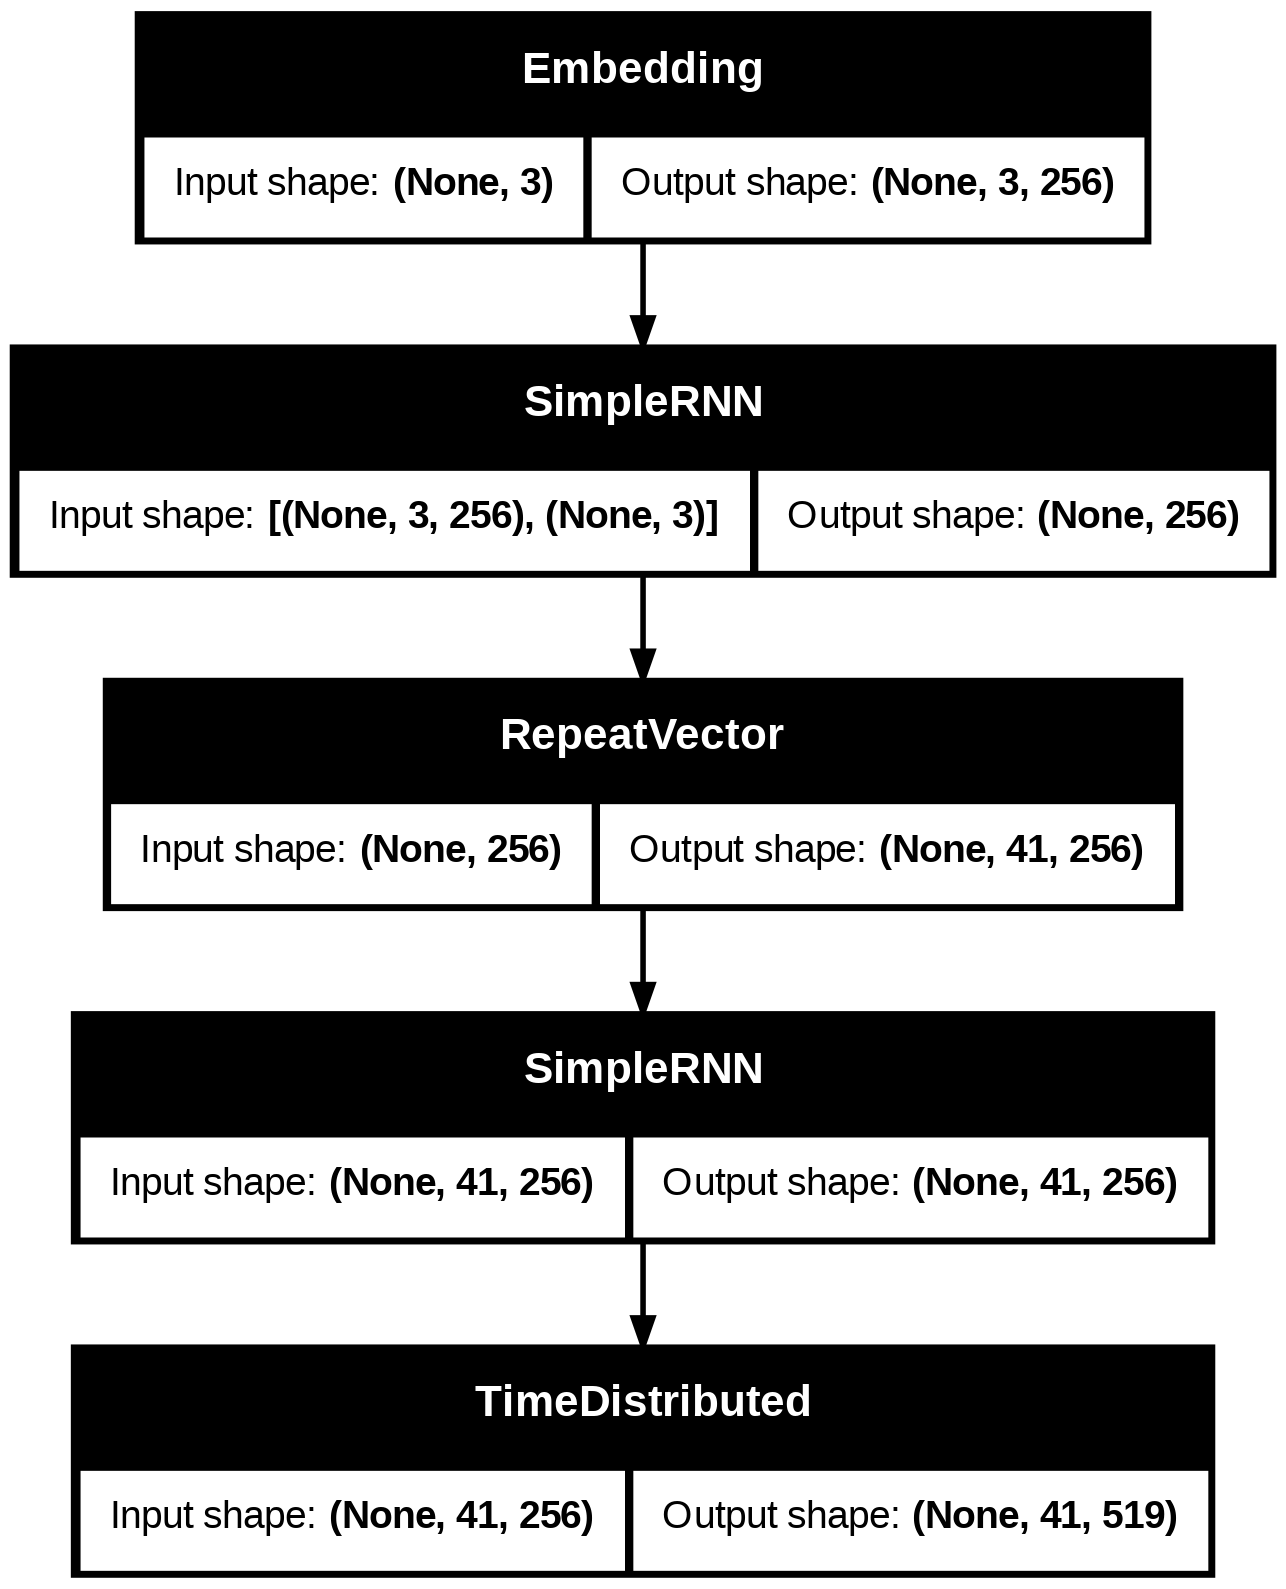

In [ ]:
print(model_translate_RNN.summary())

plot_model(model_translate_RNN, to_file='model.png', show_shapes=True)

In [ ]:
# Creating the callbacks

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

es = EarlyStopping(monitor='val_accuracy',mode='max',verbose=1,patience=40)
rl = ReduceLROnPlateau(monitor='val_accuracy',mode='max',verbose=1,patience=5,factor=0.1,min_lr=0.001)
mc = ModelCheckpoint('checkpoint/model.keras',monitor='val_accuracy',verbose=1,mode='max',save_best_only=True)

In [ ]:
filename = 'model.h5'

history_1 = model_translate_RNN.fit(trainX, trainY, epochs=30, batch_size=64, validation_split = 0.3, callbacks=[es,rl,mc])

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.0000e+00 - loss: 6.2261
Epoch 1: val_accuracy improved from -inf to 0.38537, saving model to checkpoint/model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.0000e+00 - loss: 6.2261 - val_accuracy: 0.3854 - val_loss: 5.7719 - learning_rate: 0.0010
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.3457 - loss: 5.7817
Epoch 2: val_accuracy improved from 0.38537 to 0.55854, saving model to checkpoint/model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.3457 - loss: 5.7817 - val_accuracy: 0.5585 - val_loss: 5.2283 - learning_rate: 0.0010
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.4751 - loss: 5.2905
Epoch 3: val_accuracy did not improve from 0.55854
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.4751 - loss: 5.2905 - val_accuracy: 0.5585 - val_loss: 4.7074 - learning_rate: 0.0010
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.4751 - loss: 4.8256
Epoch 4

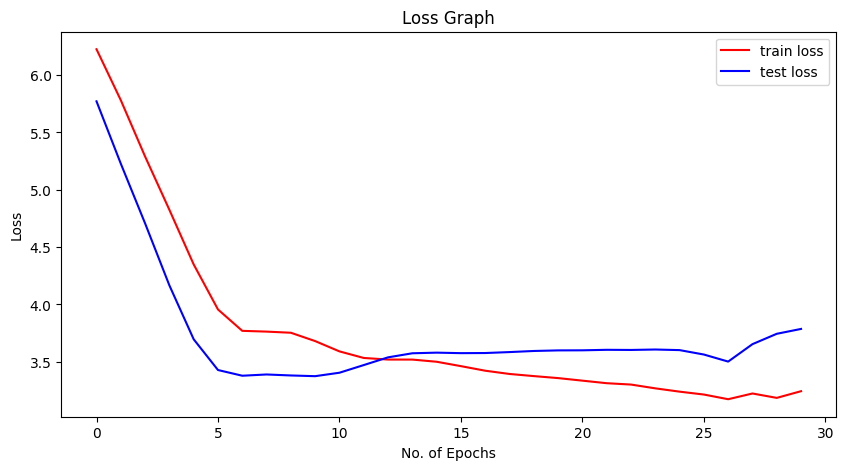

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history_1.history['loss'],'r',label='train loss')
plt.plot(history_1.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

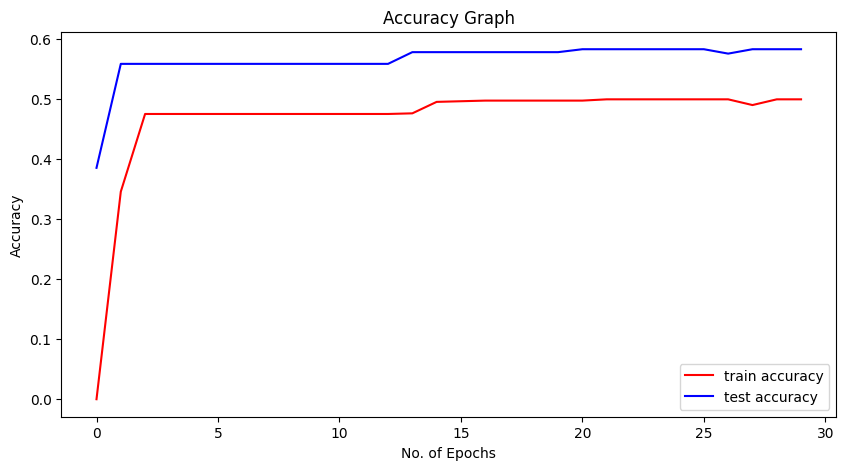

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history_1.history['accuracy'],'r',label='train accuracy')
plt.plot(history_1.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();